# Hybrid Deep GP models: combining GP and Neural Network layers

In this notebook we show how to combine `gpflux.layers.GPLayer` layers with plain Keras neural network layers. This allows one to build hybrid deep GP models. Compared to the other tutorials, we are also going to use Keras's `Sequential` model to build our hierarchical model and use a `gpflux.losses.LikelihoodLoss` instead of a `gpflux.layers.LikelihoodLayer`.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import gpflow
import gpflux

from gpflow.config import default_float

tf.keras.backend.set_floatx("float64")

2022-04-06 13:26:30.866182: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.12/x64/lib
2022-04-06 13:26:30.866216: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load Snelson dataset

We use a simple one-dimensional dataset to allow for easy plotting. To help training we normalize the input features.

In [2]:
d = np.load("../../tests/snelson1d.npz")
X, Y = data = d["X"], d["Y"]
X = (X - X.mean()) / X.std()
num_data, input_dim = X.shape

## Initialize the GP Layer

As per usual we create a one-dimensional `gpflux.layers.GPLayer` with a simple `SquaredExponential` kernel and `InducingPoints` inducing variable:

In [3]:
num_data = len(X)
num_inducing = 10
output_dim = Y.shape[1]

kernel = gpflow.kernels.SquaredExponential()
inducing_variable = gpflow.inducing_variables.InducingPoints(
    np.linspace(X.min(), X.max(), num_inducing).reshape(-1, 1)
)
gp_layer = gpflux.layers.GPLayer(
    kernel, inducing_variable, num_data=num_data, num_latent_gps=output_dim
)

2022-04-06 13:26:33.361843: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.12/x64/lib
2022-04-06 13:26:33.361874: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-06 13:26:33.361894: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fv-az121-341): /proc/driver/nvidia/version does not exist
2022-04-06 13:26:33.362209: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/runner/work/GPflux/GPflux/gpflux/la

## Sequential Keras model with GP and Neural net layers

We construct a model that consists of three `tf.keras.layers.Dense` layers and a GP. The first two Dense layers are configured to have 100 units and use a ReLU non-linearity. The last neural network layers reduces the dimension to one and does not utilise a non-linearity. We can interpret these three neural network layers as performing non-linear feature warping. The final layer in the model is the GP we defined above.

In [4]:
likelihood = gpflow.likelihoods.Gaussian(0.1)

# So that Keras can track the likelihood variance, we need to provide the likelihood as part of a "dummy" layer:
likelihood_container = gpflux.layers.TrackableLayer()
likelihood_container.likelihood = likelihood

model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(1, activation="linear"),
        gp_layer,
        likelihood_container,  # no-op, for discovering trainable likelihood parameters
    ]
)
loss = gpflux.losses.LikelihoodLoss(likelihood)

/opt/hostedtoolcache/Python/3.7.12/x64/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  after removing the cwd from sys.path.
2022-04-06 13:26:33.419643: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


We compile our model by specifying the loss and the optimizer to use. After this is done, we fit the data and plot the trajectory of the loss:

2022-04-06 13:26:33.635395: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-06 13:26:33.635913: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2593905000 Hz


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


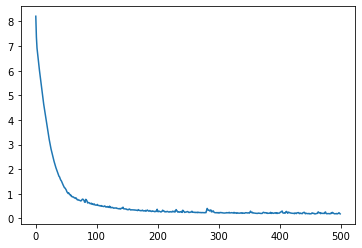

In [5]:
model.compile(loss=loss, optimizer="adam")
hist = model.fit(X, Y, epochs=500, verbose=0)
plt.plot(hist.history["loss"])

We can now inspect the final model by plotting its predictions. Note that `model(X_test)` now returns the output of the final `GPLayer` and *not* a `LikelihoodLayer`. The output of a `GPLayer` is a TFP distribution with a `mean()` and `variance()`.

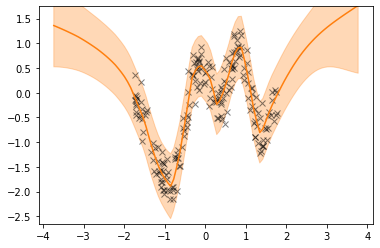

In [6]:
def plot(model, X, Y, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    x_margin = 2.0
    N_test = 100
    X_test = np.linspace(X.min() - x_margin, X.max() + x_margin, N_test).reshape(-1, 1)
    f_distribution = model(X_test)

    mean = f_distribution.mean().numpy().squeeze()
    var = f_distribution.variance().numpy().squeeze() + model.layers[-1].likelihood.variance.numpy()
    X_test = X_test.squeeze()
    lower = mean - 2 * np.sqrt(var)
    upper = mean + 2 * np.sqrt(var)

    ax.set_ylim(Y.min() - 0.5, Y.max() + 0.5)
    ax.plot(X, Y, "kx", alpha=0.5)
    ax.plot(X_test, mean, "C1")

    ax.fill_between(X_test, lower, upper, color="C1", alpha=0.3)


plot(model, X, Y)

In [7]:
gpflow.utilities.print_summary(model, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
Sequential._self_tracked_trackables[1]._trainable_weights[0] Sequential._self_tracked_trackables[1].kernel,UnliftedInitializerVariable,,,True,"(1, 100)",float64,"[[0.12183643, -0.09776788, 0.10780942..."
Sequential._self_tracked_trackables[1]._trainable_weights[1] Sequential._self_tracked_trackables[1].bias,UnliftedInitializerVariable,,,True,"(100,)",float64,"[0.10347365, -0.03022754, -0.14719294..."
Sequential._self_tracked_trackables[2]._trainable_weights[0] Sequential._self_tracked_trackables[2].kernel,UnliftedInitializerVariable,,,True,"(100, 100)",float64,"[[0.05001255, 0.15239925, 0.1436115..."
Sequential._self_tracked_trackables[2]._trainable_weights[1] Sequential._self_tracked_trackables[2].bias,UnliftedInitializerVariable,,,True,"(100,)",float64,"[0.08403021, 0.08490487, 0.03056672..."
Sequential._self_tracked_trackables[3]._trainable_weights[0] Sequential._self_tracked_trackables[3].kernel,UnliftedInitializerVariable,,,True,"(100, 1)",float64,[[-0.12026971...
Sequential._self_tracked_trackables[3]._trainable_weights[1] Sequential._self_tracked_trackables[3].bias,UnliftedInitializerVariable,,,True,"(1,)",float64,[-0.08441119]
Sequential._self_tracked_trackables[4]._metrics[0]._non_trainable_weights[0] Sequential._self_tracked_trackables[4]._metrics[0].total,UnliftedInitializerVariable,,,False,(),float64,0.2706323531567657
Sequential._self_tracked_trackables[4]._metrics[0]._non_trainable_weights[1] Sequential._self_tracked_trackables[4]._metrics[0].count,UnliftedInitializerVariable,,,False,(),float64,8.0
Sequential._self_tracked_trackables[4]._self_tracked_trackables[1].variance Sequential._self_tracked_trackables[4].kernel.variance,Parameter,Softplus,,True,(),float64,0.8172921493977767
Sequential._self_tracked_trackables[4]._self_tracked_trackables[1].lengthscales Sequential._self_tracked_trackables[4].kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.8950569791018826
